### Load modules

In [1]:
# general
import os
import sys
import time
import numpy as np 
import matplotlib.pyplot as plt 
import random as rnd

# Numpyro
import numpyro
import numpyro.distributions as npdist
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)

#JAX
import jax
from jax import random
import jax.numpy as jnp

import flax
import optax

# PyTorch
import torch
import torch.utils.data as data

# check versions
print('Pytorch version: ',   torch.__version__)
print('Numpyro version: ', numpyro.__version__)
print('JAX version:     ',     jax.__version__)
print('Flax version:    ',    flax.__version__)
print('Optax version:   ',   optax.__version__)
from platform import python_version
print('Pythorch version:',python_version())

# import priors 
#from models.priors import *

# import functions to load data
from models.data import *

# test dist_euclid
#x1 = jnp.array([1,2,3])
#dist_euclid(x1,x1)

/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


Pytorch version:  1.12.1
Numpyro version:  0.11.0
JAX version:      0.4.12
Flax version:     0.6.1
Optax version:    0.1.4
Pythorch version: 3.10.11


### Setup arguments

In [9]:
args = {"seed": 0,
        
        # architecture
        "conditional": False,   # CVAE if True, VAE otherwise
        "input_dim" : 50,
        "hidden_dim": 40,
        "latent_dim": 30,
        
        # VAE setup    
        "batch_size": 10,
       }

### Generate data


In [10]:
train_set = Dataset_GP1d(n_dataPoints=args["input_dim"], seed=42)  
val_set =   Dataset_GP1d(n_dataPoints=args["input_dim"], seed=43)  
test_set =  Dataset_GP1d(n_dataPoints=args["input_dim"], seed=44)  

train_loader, val_loader, test_loader = create_data_loaders(train_set, val_set, test_set,
                                                            train=[True, False, False],
                                                            batch_size=args["batch_size"])

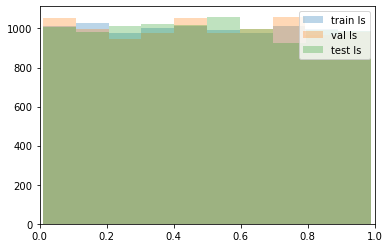

In [11]:
# what lengthscales are we generating? 

ls_train_set = train_set.ls
ls_val_set =   val_set.ls
ls_test_set = test_set.ls

plt.hist(ls_train_set, alpha = 0.3, label = 'train ls') 
plt.hist(ls_val_set,   alpha = 0.3, label = 'val ls') 
plt.hist(ls_test_set,  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()

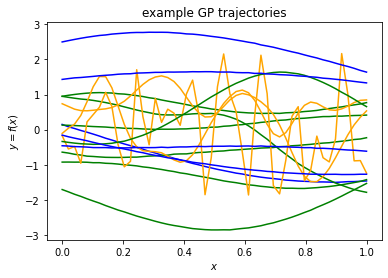

In [12]:
# what trajectories are we generating?

fig, ax = plt.subplots()
for i in range(15):
    if train_set.ls[i] <= 0.2:
        col = 'orange'
    elif train_set.ls[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(train_set.x[i], train_set.y[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('example GP trajectories')

plt.show()

### Define Model

In [7]:
from models.cvae import *

In [13]:
# 1) Model
out_dim    = args["input_dim"]
hidden_dim = args["hidden_dim"]
latent_dim = args["latent_dim"]
conditional = args["conditional"]

model = VAE(hidden_dim, latent_dim, out_dim, conditional)

### Train model